## Задание 1
## Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).


Подгружаем необходимые библиотеки

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest

In [4]:
reg= pd.read_csv('problem1-reg_data.csv', sep = ';')
reg

FileNotFoundError: [Errno 2] No such file or directory: 'problem1-reg_data.csv'

Предварительный анализ данных

In [ ]:
reg.dtypes 

Предварительный анализ данных, смотрим отсутствие null

In [ ]:
reg.info() 

In [ ]:
auth= pd.read_csv('problem1-auth_data.csv', sep = ';')
auth

In [ ]:
auth.dtypes

Предварительный анализ данных, смотрим отсутствие null

In [7]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Все знаения uid из reg_ts, пристутствуют в auth_ts	

In [8]:
len(set(auth.uid.unique()).intersection(set(reg.uid.unique()))) 

1000000

Создаем функцию для вывода retention по дням за выбранную дату:

In [35]:
def calculate_retention(reg, auth, day_first, day_end): 
    """Функция для расчёта retention по дням.

        Args:
        reg (_type_): Данные о регистрации пользователей
        auth (_type_): Данные о заходах пользователей в игру
        day_first (_type_): Дата c которой считаем retention (по этой дате определяем когорту пользователей).
        day_end (_type_): Дата до которой считаем retention.

        Returns:
        retention_month: Итоговая таблица с расчитанным retention
    """
    merged_data = reg.merge(auth, on = 'uid')
    merged_data.auth_ts = pd.to_datetime(pd.to_datetime(merged_data.auth_ts, unit='s').dt.date) #Переводим секунды в нормальную дату
    merged_data.reg_ts = pd.to_datetime(pd.to_datetime(merged_data.reg_ts, unit='s').dt.date) #Переводим секунды в нормальную дату

       
    start_date = pd.to_datetime(day_first)
    finish_date =  pd.to_datetime(day_end)
    merged_data = merged_data[(merged_data['reg_ts'] >= start_date) & (merged_data['auth_ts'] <= finish_date)] #фильтруем датафрейм по дае начала и конца из функции
    days_md = merged_data.groupby(['reg_ts', 'auth_ts'], as_index = False).agg({'uid':'nunique'}) #считаем кол-во уникальных юзеров в разбивке по времени регистрации и времни захода в игру
    days_md['days'] = (days_md.auth_ts - days_md.reg_ts).dt.days #Считаем и заводим в отдельную колонку сколько времени прошло между регистрацией и заходом в игру
    day_md_pivot = days_md.pivot_table(index = 'reg_ts', columns = 'days', values = 'uid') #Делаем сводную таблицу 
    cohort_size = day_md_pivot[0] #Размер когорты для каждой даты регистрации
    day_md_pivot = day_md_pivot.drop(columns=[0]) #Удаляем первый столбец, что бы в последствии в таблице с retention в день регистрации отображалось не 100%, а абсолютное кол-во зарегистрированных
  
    retention_month =  day_md_pivot.divide(cohort_size,  axis=0).round(3)*100 #Считаем retention на каждый день
    retention_month.insert(0, 'cohort_size', cohort_size) #Вставлем в первый день регисрации не retention, а кол-ао зарегистрированных
    retention_month['cohort_size'] = retention_month['cohort_size'].astype(int)
    
    plt.figure(figsize=(25, 20)) #Выводим значения retention по дням за определенный функцией промежуток времени
    plt.title('Значение retention (%)')
    ax = sns.heatmap(data=retention_month, fmt='.1f', annot=True, cmap='YlGnBu')
    ax.set_xlabel('Количество дней со дня регистрации')
    ax.set_ylabel('Когорта (дата регистрации)')
    plt.show()
       
    return retention_month
            

Пример

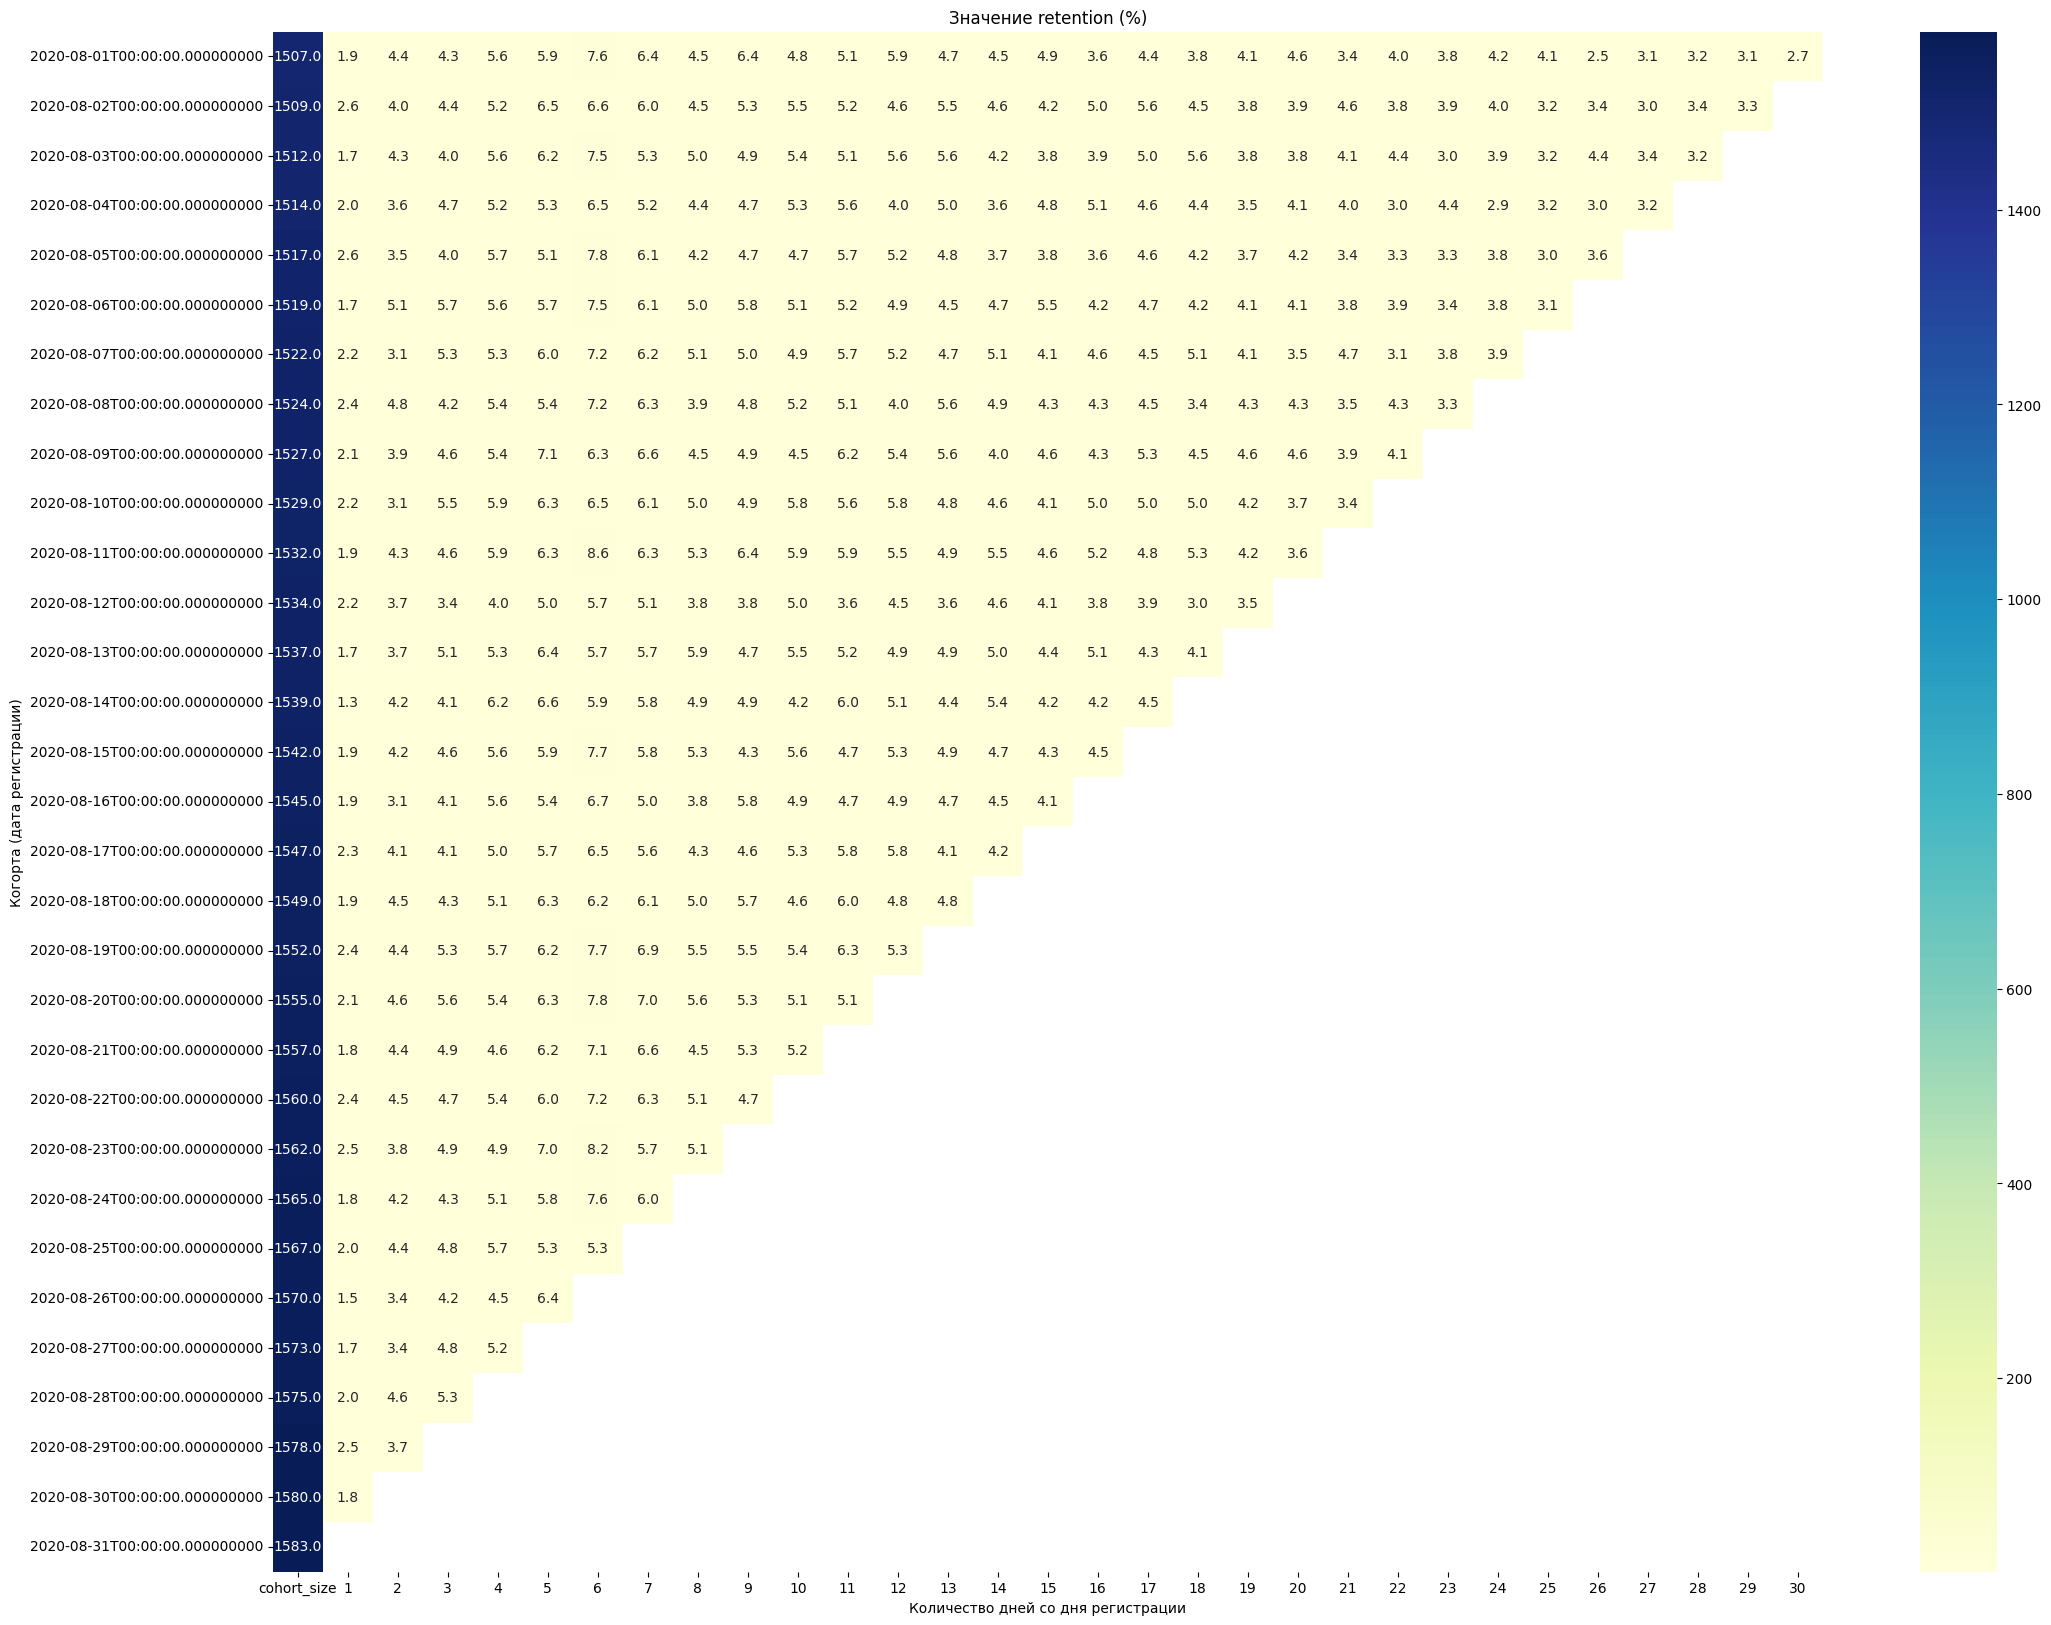

days,cohort_size,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1507,1.9,4.4,4.3,5.6,5.9,7.6,6.4,4.5,6.4,...,3.4,4.0,3.8,4.2,4.1,2.5,3.1,3.2,3.1,2.7
2020-08-02,1509,2.6,4.0,4.4,5.2,6.5,6.6,6.0,4.5,5.3,...,4.6,3.8,3.9,4.0,3.2,3.4,3.0,3.4,3.3,NaN
2020-08-03,1512,1.7,4.3,4.0,5.6,6.2,7.5,5.3,5.0,4.9,...,4.1,4.4,3.0,3.9,3.2,4.4,3.4,3.2,NaN,NaN
2020-08-04,1514,2.0,3.6,4.7,5.2,5.3,6.5,5.2,4.4,4.7,...,4.0,3.0,4.4,2.9,3.2,3.0,3.2,NaN,NaN,NaN
2020-08-05,1517,2.6,3.5,4.0,5.7,5.1,7.8,6.1,4.2,4.7,...,3.4,3.3,3.3,3.8,3.0,3.6,NaN,NaN,NaN,NaN
2020-08-06,1519,1.7,5.1,5.7,5.6,5.7,7.5,6.1,5.0,5.8,...,3.8,3.9,3.4,3.8,3.1,NaN,NaN,NaN,NaN,NaN
2020-08-07,1522,2.2,3.1,5.3,5.3,6.0,7.2,6.2,5.1,5.0,...,4.7,3.1,3.8,3.9,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08,1524,2.4,4.8,4.2,5.4,5.4,7.2,6.3,3.9,4.8,...,3.5,4.3,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-09,1527,2.1,3.9,4.6,5.4,7.1,6.3,6.6,4.5,4.9,...,3.9,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
calculate_retention(reg, auth, '2020-08-01', '2020-08-31')

## Задание 2
## Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
## Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [11]:
test = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')
test

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Проаверяем есть ли пропуски

In [12]:
test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Считаем кол-во пользоваелей в группах, делаем вывод, что тестовой является группа b

In [13]:
test.groupby('testgroup').agg({'user_id':'nunique'})

,user_id
testgroup,
a,202103
b,202667


Определяем, что пересечений по пользователям между группами нет

In [14]:
test_gr_a_set = set(test['user_id'][test['testgroup'] == 'a'].unique()) 
test_gr_b_set = set(test['user_id'][test['testgroup'] == 'b'].unique())
test_gr_a_set.intersection(test_gr_b_set)

set()

Смотрим как распределена выручка по группам. Вывод: распредение не нормальное

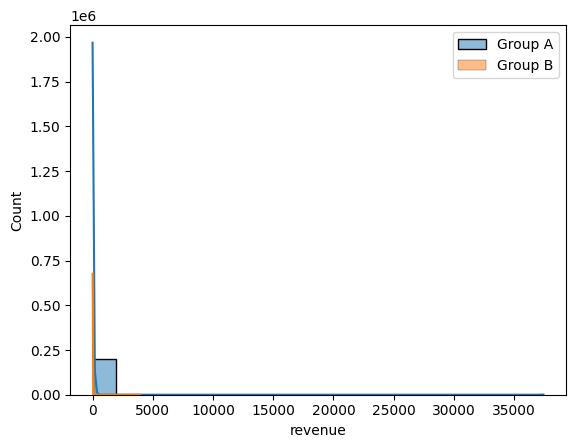

In [15]:
revenue_control_group = test[test['testgroup'] == 'a']['revenue']
revenue_test_group = test[test['testgroup'] == 'b']['revenue']
_ = sns.histplot(revenue_control_group, kde=True, label='Group A')
_ = sns.histplot(revenue_test_group, kde=True, label='Group B')
_ = plt.legend()
plt.show()

### Рассмотрим метрики ARPU, ARPPU и Конверсию

ARPU (AverageRevenuePerUser) – это средний доход с пользователя

Cчитаем  ARPU для каждой из групп

In [16]:

test.groupby('testgroup').agg({'revenue':'mean'}).rename(columns={'revenue':'ARPU'}) 

,ARPU
testgroup,
a,25.413720
b,26.751287


Проверка нормальности распределения (тест Шапиро-Уилка) . Нулевая гипотеза - данные распределены нормально.

ВЫВОД: так как p_value меньше 0.05 , то данные распределены не нормально

In [17]:

_, p_value_shapiro_a = stats.shapiro(test[test['testgroup'] == 'a']['revenue'])
_, p_value_shapiro_b = stats.shapiro(test[test['testgroup'] == 'b']['revenue'])

print("P-value для теста Шапиро-Уилка (группа a):", p_value_shapiro_a)
print("P-value для теста Шапиро-Уилка (группа b):", p_value_shapiro_b)

P-value для теста Шапиро-Уилка (группа a): 9.154085373057082e-204
P-value для теста Шапиро-Уилка (группа b): 1.2462736534200747e-201


D:\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 202103.
  res = hypotest_fun_out(*samples, **kwds)
D:\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 202667.
  res = hypotest_fun_out(*samples, **kwds)


Смотрим распределение данных графически, подтверждается, что они распрелеоен не нормально

<Axes: ylabel='Frequency'>

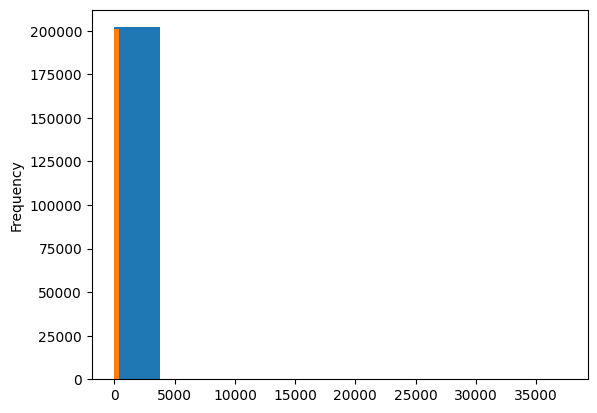

In [18]:
revenue_by_group_a = test[test['testgroup'] == 'a']['revenue'] 
revenue_by_group_b = test[test['testgroup'] == 'b']['revenue']
revenue_by_group_a.plot(kind='hist')
revenue_by_group_b.plot(kind='hist')

Выполнение теста Левене. Нулевая гипотеза - дисперсии гомогенны.

ВЫВОД: раз p_value > 0.05, СЛЕДОВАТЕЛЬНО ДИСПЕРСИИ РАВНЫ (ГОМОГЕННЫ)

In [19]:
stat, p_value = levene(revenue_by_group_a, revenue_by_group_b)
print(f"Статистика: {stat}, p-значение: {p_value}")


Статистика: 0.3896289474701388, p-значение: 0.5324948591043842


Проведение t-теста, если данные удовлетворяют требованиям. Не смотря на то, что данные распределены не нормально, у нас выборка больше 30 и t-тес применим.  Нулевая гипотеза- статистических различий между ARPU группы a и b -нет

#### ВЫВОД: На основе даннных АВ-теста мы не можем сделать вывод, что ARPU имеет статзначимое различие в группах a и b. Средних доход на пользователя в группе b статистически не увеличился

Считаем  ARPPU по группам 

In [20]:
revenue_by_group_a_mean = test[(test['testgroup'] == 'a') & (test['revenue'] > 0)]['revenue'].mean()
revenue_by_group_b_mean = test[(test['testgroup'] == 'b') & (test['revenue'] > 0)]['revenue'].mean()
print("ARPPU в группе a:", revenue_by_group_a_mean)
print("ARPPU в группе b:", revenue_by_group_b_mean)

ARPPU в группе a: 2663.9984439834025
ARPPU в группе b: 3003.6581717451522


Проверка нормальности распределения (тест Шапиро-Уилка) . Нулевая гипотеза - данные распределены нормально.

ВЫВОД: так как p_value меньше 0.05, то данные распределены не нормально

In [21]:
_, p_value_shapiro_a_arppu  = stats.shapiro(test[(test['testgroup'] == 'a') & (test['revenue'] > 0)]['revenue'])
_, p_value_shapiro_b_arppu  = stats.shapiro(test[(test['testgroup'] == 'b') & (test['revenue'] > 0)]['revenue'])

print("P-value для теста Шапиро-Уилка (группа a):", p_value_shapiro_a_arppu )
print("P-value для теста Шапиро-Уилка (группа b):", p_value_shapiro_b_arppu )

P-value для теста Шапиро-Уилка (группа a): 6.429637191232859e-66
P-value для теста Шапиро-Уилка (группа b): 2.491925378538669e-22


Выполнение теста Левене. Нудевая гипотеза - дисперсии гомогенны.

ВЫВОД: так как p_value < 0.05, СЛЕДОВАТЕЛЬНО ДИСПЕРСИИ НЕ РАВНЫ (НЕ ГОМОГЕННЫ)

In [22]:
revenue_by_group_a_arppu = test[(test['testgroup'] == 'a') & (test['revenue'] > 0)]['revenue']
revenue_by_group_b_arppu = test[(test['testgroup'] == 'b') & (test['revenue'] > 0)]['revenue']
stat, p_value = levene(revenue_by_group_a_arppu, revenue_by_group_b_arppu)

print(f"Статистика: {stat}, p-значение: {p_value}")

Статистика: 80.85567421779912, p-значение: 3.779689868667878e-19


Если дисперсии не гомогенны, используем t-тест Уэлча. Не смотря на то, что данные распределены не нормально, у нас выборка больше 30 и t-тес применим.  Нулевая гипотеза- статистических различий между ARPPU группы a и b -нет

In [23]:
t_stat, p_value_t_test = stats.ttest_ind(revenue_by_group_a_arppu, revenue_by_group_b_arppu,  equal_var=False)
print("T-статистика:", t_stat)
print("P-value для t-теста:", p_value_t_test) # P-value больше 0.05 , следовательно нулевую гипотезу не оклоняем

T-статистика: -1.644630266430084
P-value для t-теста: 0.10020780398916015


#### ВЫВОД: На основе даннных АВ-еста мы не можем сделать вывод, что ARPPU имеет статзначимое различие в группах a и b

Считаем конверсию по группам. Конверсия = (Paying Users / Total Users) – доля пользователей совершивших покупку

In [24]:
Conversion_b = (test[(test['testgroup'] == 'b') & (test['revenue'] > 0)]['user_id'].count() / test[test['testgroup'] == 'b']['user_id'].count()) 
                
Conversion_b

np.float64(0.008906235351586593)

Ситаем число пользоваелей совершивших покупку по группам

In [25]:

paying_users_a = test[(test['testgroup'] == 'a') & (test['revenue'] > 0)]
paying_users_b = test[(test['testgroup'] == 'b') & (test['revenue'] > 0)]
print("Число пользователей совершивших покупку в группе a - ", len(paying_users_a),
    
      "Число пользователей совершивших покупку в группе b - ", len(paying_users_b))

Число пользователей совершивших покупку в группе a -  1928 Число пользователей совершивших покупку в группе b -  1805


Используем z-тест Нулевая гипотеза - стат. значимых различий  нет.

In [26]:
count = [len(paying_users_a), len(paying_users_b)] 
nobs = [len(test[test['testgroup'] == 'a']), len(test[test['testgroup'] == 'b'])]
z_stat, p_value = proportions_ztest(count, nobs)
print(f'Z-test for proportions: z-statistic={z_stat}, p-value={p_value}')

Z-test for proportions: z-statistic=2.108028495889841, p-value=0.035028524642854865


ВЫВОД: так как p-value меньше 0.05, отвергшаем нудевую гипотезу и делаем вывод, чтомежду группами a и b есть стат значимые различия в части конверсий

#### Вывод: так как в группе a конверсия сатистически значимо больше, чем в тесовой группе. Следлваельно набор предложений для группы a - лучше чем для группы b.

Смотрим распреденение выручки по группе a

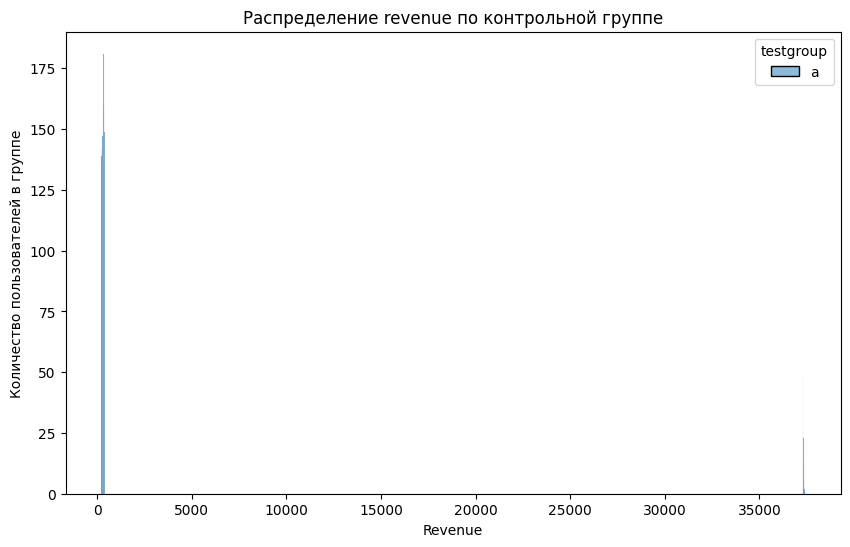

In [27]:
_ = plt.figure(figsize=(10, 6))
_ = sns.histplot(x = 'revenue', data = paying_users_a, hue = 'testgroup').set_title('Распределение revenue по контрольной группе')
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Количество пользователей в группе')

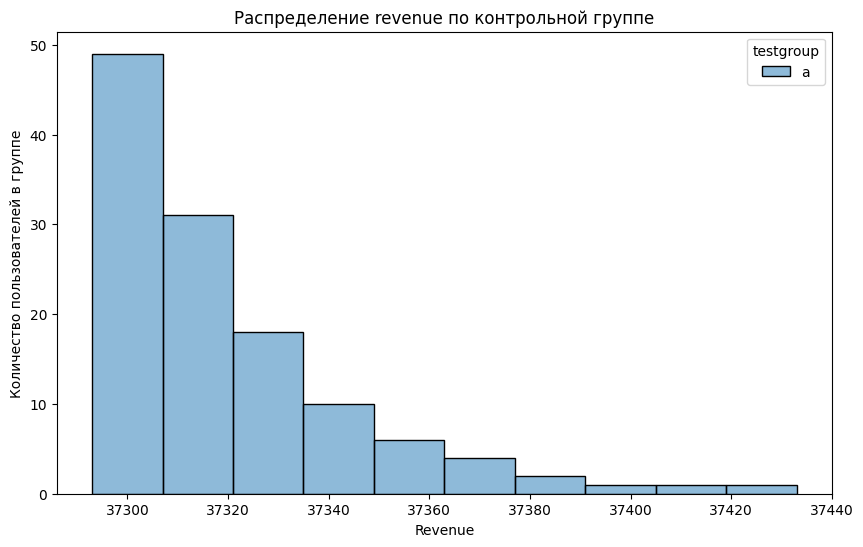

In [28]:

_ = plt.figure(figsize=(10, 6))
_ = sns.histplot(x = 'revenue', data = paying_users_a[paying_users_a['revenue'] > 5000], hue = 'testgroup', bins=10).set_title('Распределение revenue по контрольной группе')
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Количество пользователей в группе')

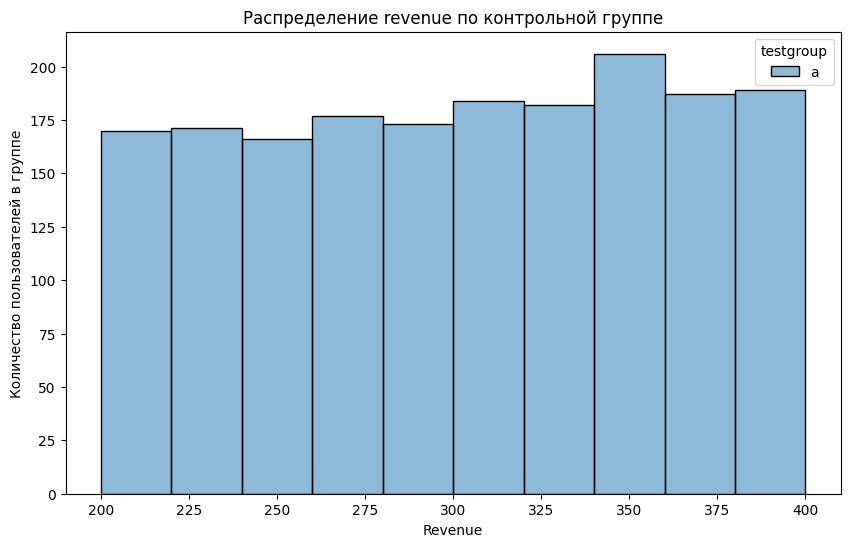

In [29]:
_ = plt.figure(figsize=(10, 6))
_ = sns.histplot(x = 'revenue', data = paying_users_a[paying_users_a['revenue'] < 5000], hue = 'testgroup', bins=10).set_title('Распределение revenue по контрольной группе')
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Количество пользователей в группе')

Смотрим распреденение выручки по группе b

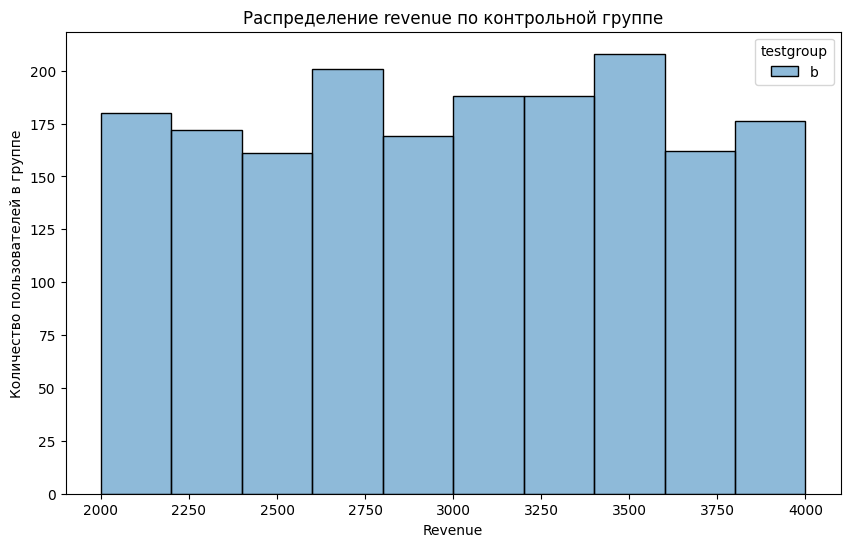

In [30]:
_ = plt.figure(figsize=(10, 6))
_ = sns.histplot(x = 'revenue', data = paying_users_b, hue = 'testgroup', bins=10).set_title('Распределение revenue по контрольной группе')
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Количество пользователей в группе')

## Вывод: выручка в группе а распределяется от 200 до 400 у.е. на покупателя и от 37000 до 37500 у.е. на очень малый процент покупателей, а в группе b основаня масса покупателей приносит о 2000 до 4000 у.е. Из чего можно сделать предположение, что возможно дизайн теста был не совсем корректен и сплитование проводилось с ошибкой. Нужно уточнить у тех ко проводил тест было ли так задумано?
## В случае если так задумано и было и разным группам были предложены различные акционные предложения, то так как статзначимые различия обнаружились только в Conversion, при этом в тестовой группе b конверсия стала  меньше, то можно сделать вывод, что новые акции выкатывать не стоит.

## Задание 3

## Описание задания:
## В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для ## сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?
## Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на ##несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?


Ответ на вопрос: С помощью каких метрик можно оценить результаты последнего прошедшего события?

Метрики  в игровой индустрии можно условно разделить на:
1. Метрики привлечения
2. Метрики активности
3. Метрики выручки
Для решения нашего задания мы будем рассматривать метрики активности и метрики выручки.

 Из метрик активноси для нашего случая могут подойти:
 1. Retention (измеряет удержание пользователей) - сможем посмотреть как проведение события в игре влияет на возвращаемость пользователей (стали ли они чаще или реже возвращаться в игру). Высокий retention будет говорить нам об удовлетворенности игроков и заинтересованности событием.
 2. DAU, WAU, MAU (количество уникальных пользователей за сутки/неделю/месяц в зависимости от длительности события). Для примера можно сравнить кол-во пользователей в дни с тематическими событиями и в обычные дни.
 3. Session Length (длительность сессии),среднее время игровой сессии (сравнить во время события и в обычное время).
количество участников - оценить привлекло ли событие больше пользователей в игру.
 4. Conversion rate (конверсия) - посмотрим какая доля пользователей прошла ряд уровней за определенное время и получила награду. Высокий уровень conversion rate может говорить нам о том, что событие было легкопроходимым и интересовало пользователей до самого конца (либо их сильно мотивировала итоговая награда).
 
 Из метрик выручки нам подойдут:
 1. ARPU (Average Revenue Per User) – это средняя выручка на одного игрока за определённый период времени (в нашем случае подойдет месяц)
 2. ARPPU (Average Revenue Per Paying User)  - это средняя выручка на одного платящего игрока за определённый период времени
 3. Общая выручка за период  - период в который происходит событие и аналогичный период до события, например если событие длится неделю, то неделя до события и неделя во время самого события.
 4. Конверсия из не платящего в платящего пользователя.
 
 Ответ на вопрос: Изменится ли набор метрик оценки результата? Если да, то как?
 
Некоторые метрики можно оставить(все метрики выручки, длину сессии и Retention), но также дополнительно стоит посмотреть процент откатов - долю игроков, которая сталиквается с откатом на другой уровень для того, чтобы понять насколько сложнее стала игра. Очень важно проанализировать revenue (доходность), чтобы отследить как изменился наш доход от игры при усложнении механики событий.

Из выбранных выше метрик особое внимание нужно будет уделить retention, чтобы понять стало ли уходить больше пользователей и на какой день после усложнения механики игры они ушли.
 
 Смотря на Session Length нужно учитывать, что среднее время сессии может увеличится не за счет того, что пользователю игра стала больше нравится, а из-за того, что новая усложненная механика подразумевает большую затрату времени на те же действия.
 Так же можно обратить внимание на Конверсию перехода между уровнями, сравнить какая она была до ввода усложнения механики и после.